In [3]:
import pandas as pd
import numpy as np
import graph_tool as gt
import datetime
import itertools as it
import matplotlib.pyplot as plt
from graph_tool import stats as gt_stats
from graph_tool.draw import graph_draw

In [4]:
#### READ IN THE DATASETS

co_offending_table = pd.read_csv('./raw_datasets/Cooffending.csv')
crimes = pd.read_csv('./processed_datasets/crime_type_mapping.csv')

#### CLEAN 
co_offending_table.drop_duplicates(inplace=True)

def crime_category_to_int(x):
    if x == 'x':
        return(0)
    else:
        return(int(x))

crimes['criminology_category'] = crimes.criminology_category.apply(lambda x: crime_category_to_int(x))

# Format the crime labels with 0 corresponding to a missing value 
def crime_code_to_int(x):
    if x == ' ':
        return 0 
    else:
        return int(x)
    
co_offending_table['NCD1'] = co_offending_table.NCD1.apply(lambda x: crime_code_to_int(x))
co_offending_table['NCD2'] = co_offending_table.NCD2.apply(lambda x: crime_code_to_int(x))
co_offending_table['NCD3'] = co_offending_table.NCD3.apply(lambda x: crime_code_to_int(x))
co_offending_table['NCD4'] = co_offending_table.NCD4.apply(lambda x: crime_code_to_int(x))

# Only look at entries that have crime identified 
co_offending_table = co_offending_table[co_offending_table.NCD1 != 0]

In [ ]:
## Contructing the Network

def build_crime_relationship_graph(crime_df, co_offending_df):
    # verticies are crime codes
    N = len(crime_df['crime_code'])
    
    # represent as a graph
    g= gt.Graph(directed=False)
    g.add_vertex(N)
    
    # store properties     
    crime_description = g.new_vertex_property("string")
    crime_code = g.new_vertex_property("int")
    crime_category = g.new_vertex_property("int")
    drug_crime = g.new_vertex_property("int")
    edge_weight = g.new_edge_property("int")
    
    # also keep a mapping from vertex indicies back to crime codes
    crime_code_to_index = {}
    
    for (vertex_index, row) in crime_df.iterrows():
        crime_description[vertex_index] = row['text_description']
        crime_code[vertex_index] = row['crime_code']
        crime_category[vertex_index] = row['criminology_category']
        drug_crime[vertex_index] = row['drug_crime']
        crime_code_to_index[row['crime_code']] = vertex_index
    
    print('nodes added')
    # get an iterator over edges
    crimes_committed_together = co_offending_table.groupby('NoUnique').apply(
        lambda x: it.combinations(map(lambda y: crime_code_to_index[y], x.NCD1.values), 2))
    
    print('edge iterator built')
    
    # go through an calculate the weights 
    edges_with_weights = {}
    for pair in crimes_committed_together:
        for (vertex_1, vertex_2) in pair:
            if vertex_1 == vertex_2:
                continue
            if (vertex_1, vertex_2) in edges_with_weights.keys() and (vertex_2, vertex_1) in edges_with_weights.keys():
                edges_with_weights[(vertex_1, vertex_2)] += 1
                edges_with_weights[(vertex_2, vertex_1)] += 1
            else:
                edges_with_weights[(vertex_1, vertex_2)] = 1 
                edges_with_weights[(vertex_2, vertex_1)] = 1
    
    print('edge weights calulated')
    print('adding edges to graph')
    
    # now add edges and weights to the graph 
    for (edge, weight) in edges_with_weights.items():
        vertex_1 = edge[0]
        vertex_2 = edge[1]
        g.add_edge(vertex_1, vertex_2)
        edge_weight[(vertex_1, vertex_2)] = weight
    
    print('edges added to graph')
        
    g.edge_properties['weight'] = edge_weight
    g.vertex_properties['crime_code'] = crime_code
    g.vertex_properties['crime_description'] = crime_description
    g.vertex_properties['criminology_category'] = crime_category
    g.vertex_properties['drug_crime'] = drug_crime
    
    # also remove the parallel edges 
    gt.stats.remove_parallel_edges(g)
    
    return(g)

In [ ]:
g = build_crime_relationship_graph(crimes, co_offending_table)

In [ ]:
g.save("./crime_type_graph.gml")

In [28]:
g= gt.Graph(directed=False)
g.load(file_name="./crime_type_graph.gml")

In [37]:
g.set_vertex_filter(None)

In [38]:
print(g.num_vertices(), g.num_edges())

385 13775


In [40]:
degree_map = g.degree_property_map('out',weight=g.edge_properties['weight'])
log_degree_map = g.degree_property_map('out',weight=g.edge_properties['log_weight'])

In [41]:
log_weight = g.new_edge_property("float")

for edge in g.edges():
    if g.edge_properties['weight'][edge] == 0:
        log_weight[edge] = 0
    else:
        log_weight[edge] = np.log(g.edge_properties['weight'][edge])

g.edge_properties['log_weight'] = log_weight

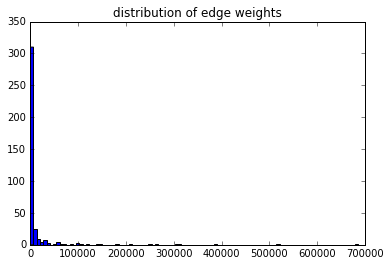

In [42]:
weights = [degree_map[vertex] for vertex in g.vertices()]
plt.hist(weights, bins=100)
plt.title('distribution of edge weights')
plt.show()

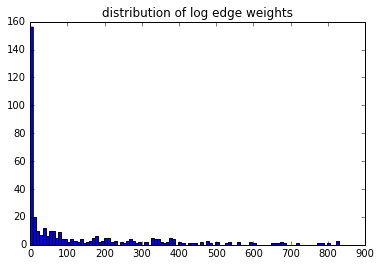

In [53]:
log_weights = [log_degree_map[vertex] for vertex in g.vertices()]
plt.hist(log_weights, bins=100)
plt.title('distribution of log edge weights')
plt.show()

In [54]:
filter_map = g.new_vertex_property('bool')

In [50]:
np.percentile(weights, 50) # we take the crimes for which we have the most information

165.0

In [56]:
for vertex in g.vertices():
    if degree_map[vertex] > 165 and g.vertex_properties['criminology\x00category'][vertex] != 0:
        filter_map[vertex] = True
    else:
        filter_map[vertex] =  False

In [59]:
g.set_vertex_filter(filter_map)

In [60]:
print(g.num_vertices(), g.num_edges())

129 5371


In [82]:
block_model_unweighted_3_class = gt.inference.minimize_blockmodel_dl(g,B_max=3, B_min=3)

In [83]:
block_model_unweighted_3_class.entropy()

7065.9966425316597

In [84]:
block_model_unweighted_multi_class = gt.inference.minimize_blockmodel_dl(g, B_max=None, B_min=None)

In [85]:
block_model_unweighted_multi_class.entropy()

7065.9966425316597

In [86]:
block_model_weighted_3_class = gt.inference.minimize_blockmodel_dl(g,B_max=3, B_min=3, state_args=dict(recs=[g.edge_properties['weight']],
                                                               rec_types=["discrete-geometric"]))

In [87]:
block_model_weighted_3_class.entropy()

31027.716593018391

In [88]:
block_model_weighted_multi_class = gt.inference.minimize_blockmodel_dl(g,B_max=None, B_min=None, state_args=dict(recs=[g.edge_properties['weight']],
                                                               rec_types=["discrete-geometric"]))

In [89]:
block_model_weighted_multi_class.entropy()

29350.145954668893

In [90]:
block_model_log_weighted_3_class = gt.inference.minimize_blockmodel_dl(g,B_max=3, B_min=3, state_args=dict(recs=[g.edge_properties['log_weight']],
                                                               rec_types=["real-exponential"]))

In [91]:
block_model_log_weighted_3_class.entropy()

15366.115460819847

In [92]:
block_model_log_weighted_multi_class = gt.inference.minimize_blockmodel_dl(g,B_max=None, B_min=None, state_args=dict(recs=[g.edge_properties['log_weight']],
                                                               rec_types=["real-exponential"]))

In [93]:
block_model_log_weighted_multi_class.entropy()

15064.939622687574

In [94]:
models = [block_model_unweighted_3_class, block_model_unweighted_multi_class, 
          block_model_weighted_3_class, block_model_weighted_multi_class,
          block_model_log_weighted_3_class, block_model_log_weighted_multi_class]

In [74]:
def get_results_of_block_model(model, graph):
    rows = []
    for vertex in graph.vertices():
        crime_code = graph.vertex_properties['crime\x00code'][vertex]
        crime_description = graph.vertex_properties['crime\x00description'][vertex]
        criminology_category = graph.vertex_properties['criminology\x00category'][vertex]
        drug_crime = graph.vertex_properties['drug\x00crime'][vertex]
        group = model.b[vertex]
        rows.append({'crime_code': crime_code, 
                     'crime_description': crime_description, 
                     'criminology_category': criminology_category,
                     'drug_crime': drug_crime,
                     'group':group})
    result = pd.DataFrame(rows)
    return(result)
    

In [75]:
def visualize_distribution(grouping_df):
    plt.hist(grouping_df.group,
             range=(0,max(grouping_df.group)), bins=max(grouping_df.group)+1)
    plt.show()

In [76]:
def print_group_members_and_stats(grouping_df):
    groups = np.unique(grouping_df.group)
    for group in groups:
        print("-------------------- GROUP %i -----------------------" % group)
        count_total = len(grouping_df[grouping_df.group == group])
        count_category_0 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 0)])
        count_category_1 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 1)])
        count_category_2 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 2)])
        count_category_3 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 3)])
        count_drug = len(grouping_df[(grouping_df.group == group) & (grouping_df.drug_crime == 1)])
        print('count: %i' % count_total)
        print('share of category 1: %f' % (count_category_1/count_total))
        print('share of category 2: %f' % (count_category_2/count_total))
        print('share of category 3: %f' % (count_category_3/count_total))
        print('share of drug crime: %f' % (count_drug/count_total))
        print(grouping_df[grouping_df.group == group][['crime_description', 'criminology_category']])

In [77]:
def print_crime_category_distribution(crime_df):
    count_total = len(crime_df)
    count_category_0 = len(crime_df[(crime_df.criminology_category == 0)])
    count_category_1 = len(crime_df[(crime_df.criminology_category == 1)])
    count_category_2 = len(crime_df[(crime_df.criminology_category == 2)])
    count_category_3 = len(crime_df[(crime_df.criminology_category == 3)])
    count_drug = len(crime_df[(crime_df.drug_crime == 1)])
    print('count: %i' % count_total)
    print('share of category 1: %f' % (count_category_1/count_total))
    print('share of category 2: %f' % (count_category_2/count_total))
    print('share of category 3: %f' % (count_category_3/count_total))
    print('share of drug crime: %f' % (count_drug/count_total))

In [78]:
def print_group_stats(grouping_df):
    groups = np.unique(grouping_df.group)
    print("-------------------- PRIOR -----------------------")
    print_crime_category_distribution(grouping_df)
    for group in groups:
        print("-------------------- GROUP %i -----------------------" % group)
        count_total = len(grouping_df[grouping_df.group == group])
        count_category_0 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 0)])
        count_category_1 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 1)])
        count_category_2 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 2)])
        count_category_3 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 3)])
        count_drug = len(grouping_df[(grouping_df.group == group) & (grouping_df.drug_crime == 1)])
        print('count: %i' % count_total)
        print('share of category 1: %f' % (count_category_1/count_total))
        print('share of category 2: %f' % (count_category_2/count_total))
        print('share of category 3: %f' % (count_category_3/count_total))
        print('share of drug crime: %f' % (count_drug/count_total))
        

In [96]:
def analyze_model(model):
    results_df = get_results_of_block_model(model, g)
    print_group_stats(results_df)
    print_group_members_and_stats(results_df)

In [97]:
def analyze_models(models):
    for model in models:
        print("MODEL %s" % str(model))
        analyze_model(model)
        print("\n\n\n\n")

In [98]:
analyze_models(models)

MODEL <BlockState object with 3 blocks (3 nonempty), degree-corrected, for graph <Graph object, undirected, with 129 vertices and 5371 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f6644f0c358, at 0x7f66443232b0>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f6644f0c358, at 0x7f6644323198>, False) at 0x7f6644f0c358>, at 0x7f6644389da0>
-------------------- PRIOR -----------------------
count: 129
share of category 1: 0.325581
share of category 2: 0.232558
share of category 3: 0.441860
share of drug crime: 0.186047
-------------------- GROUP 0 -----------------------
count: 41
share of category 1: 0.341463
share of category 2: 0.048780
share of category 3: 0.609756
share of drug crime: 0.219512
-------------------- GROUP 1 -----------------------
count: 46
share of category 1: 0.369565
share of category 2: 0.326087
share of category 3: 0.304348
share of drug crime: 0.

share of drug crime: 0.214286
             crime_description  criminology_category
8           AGRESSION SEXUELLE                   1.0
13   AGR.ARMEE OU LESIONS NIV2                   1.0
14         VOIES DE FAIT NIV.1                   1.0
21        HARCELEMENT CRIMINEL                   1.0
24        PROFERER DES MENACES                   1.0
26                       RECEL                   3.0
36   POS ARMES EN CONTRAV ORDO                   3.0
37         POSSESSION D''ARMES                   3.0
41    INFRACTION CAUTIONNEMENT                   3.0
45          COCAINE POSSESSION                   3.0
46    AUTRE SUBSTANCE POSSESS.                   3.0
47         CANNABIS POSSESSION                   3.0
51              COCAINE TRAFIC                   3.0
53             CANNABIS TRAFIC                   3.0
59       VOIE DE FAIT POLICIER                   1.0
60     VOIE DE FAIT AGENT PAIX                   1.0
62               SEQUESTRATION                   1.0
63   VOL QUALIFI

-------------------- GROUP 9 -----------------------
count: 4
share of category 1: 0.250000
share of category 2: 0.500000
share of category 3: 0.250000
share of drug crime: 0.250000
-------------------- GROUP 10 -----------------------
count: 12
share of category 1: 0.083333
share of category 2: 0.750000
share of category 3: 0.166667
share of drug crime: 0.000000
-------------------- GROUP 11 -----------------------
count: 6
share of category 1: 0.000000
share of category 2: 1.000000
share of category 3: 0.000000
share of drug crime: 0.000000
-------------------- GROUP 12 -----------------------
count: 4
share of category 1: 0.000000
share of category 2: 0.750000
share of category 3: 0.250000
share of drug crime: 0.000000
-------------------- GROUP 0 -----------------------
count: 37
share of category 1: 0.432432
share of category 2: 0.000000
share of category 3: 0.567568
share of drug crime: 0.189189
             crime_description  criminology_category
0        MEURTRE PREMIER DEGRE  